In [761]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [762]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# preprocessing and visualisation

In [763]:
df=pd.read_csv("data.csv")

In [764]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.100763,0.101999,0.099546,0.100763,9.767604e+07
1,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07
2,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
3,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
4,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08


In [765]:
df.tail()

,Date,Open,High,Low,Close,Volume
10075,2024-08-30,230.190,230.40,227.48,229.00,52990770.0
10076,2024-09-03,228.550,229.00,221.17,222.77,50190574.0
10077,2024-09-04,221.660,221.78,217.48,220.85,43840196.0
10078,2024-09-05,221.625,225.48,221.52,222.38,36615398.0
10079,2024-09-06,223.950,225.24,219.77,220.86,48370990.0


In [766]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10080 non-null  object 
 1   Open    10080 non-null  float64
 2   High    10080 non-null  float64
 3   Low     10080 non-null  float64
 4   Close   10080 non-null  float64
 5   Volume  10080 non-null  float64
dtypes: float64(5), object(1)
memory usage: 472.6+ KB


In [767]:
df.describe()

,Open,High,Low,Close,Volume
count,10080.000000,10080.000000,10080.000000,10080.000000,1.008000e+04
mean,24.212653,24.474183,23.962728,24.228588,3.901825e+08
std,48.475894,48.997820,47.988301,48.513977,4.026818e+08
min,0.055411,0.056019,0.054803,0.054803,2.811754e+06
25%,0.292936,0.298629,0.286002,0.292288,1.385973e+08
50%,0.884054,0.907432,0.864364,0.883006,2.576699e+08
75%,21.635500,21.869775,21.426925,21.649000,4.927167e+08
max,236.480000,237.230000,233.090000,234.820000,8.706575e+09


### checking for duplicates and null values

In [768]:
df.duplicated().sum()

0

In [769]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

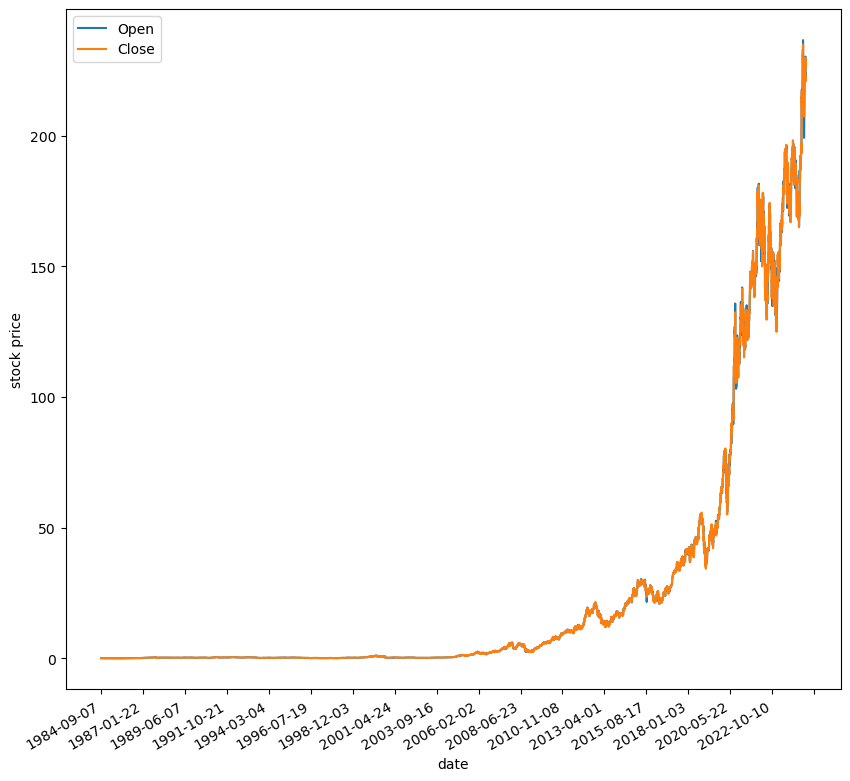

In [770]:
plt.figure(figsize=(10,10))
plt.plot(df["Date"],df["Open"])
plt.plot(df["Date"],df["Close"])
plt.legend(['Open','Close'])
plt.xlabel('date')
plt.ylabel('stock price')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.gcf().autofmt_xdate()

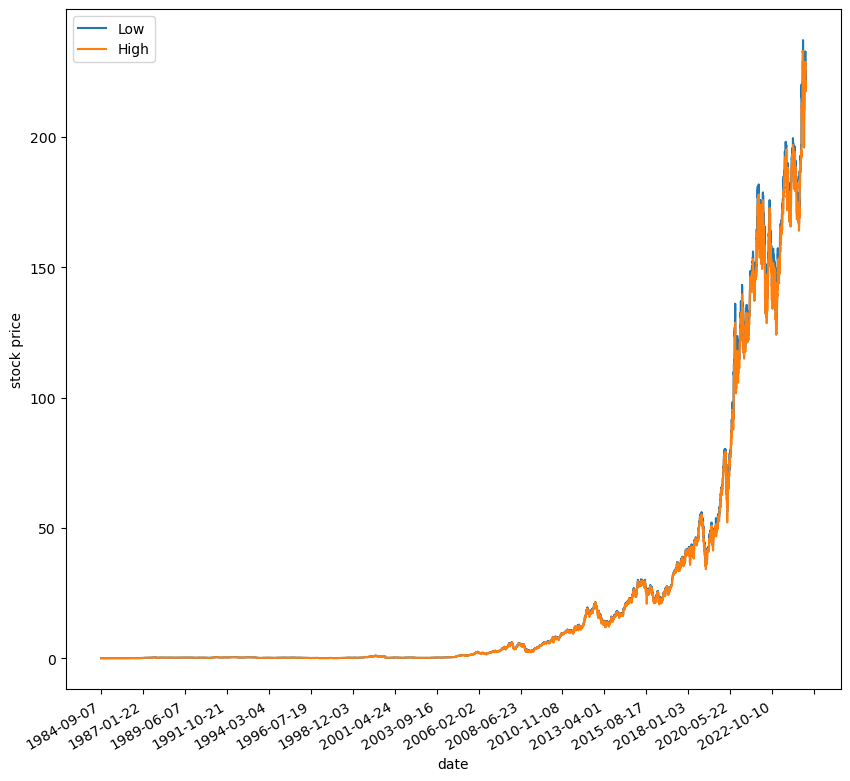

In [771]:
plt.figure(figsize=(10,10))
plt.plot(df["Date"],df["High"])
plt.plot(df["Date"],df["Low"])
plt.legend(['Low','High'])
plt.xlabel('date')
plt.ylabel('stock price')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.gcf().autofmt_xdate()

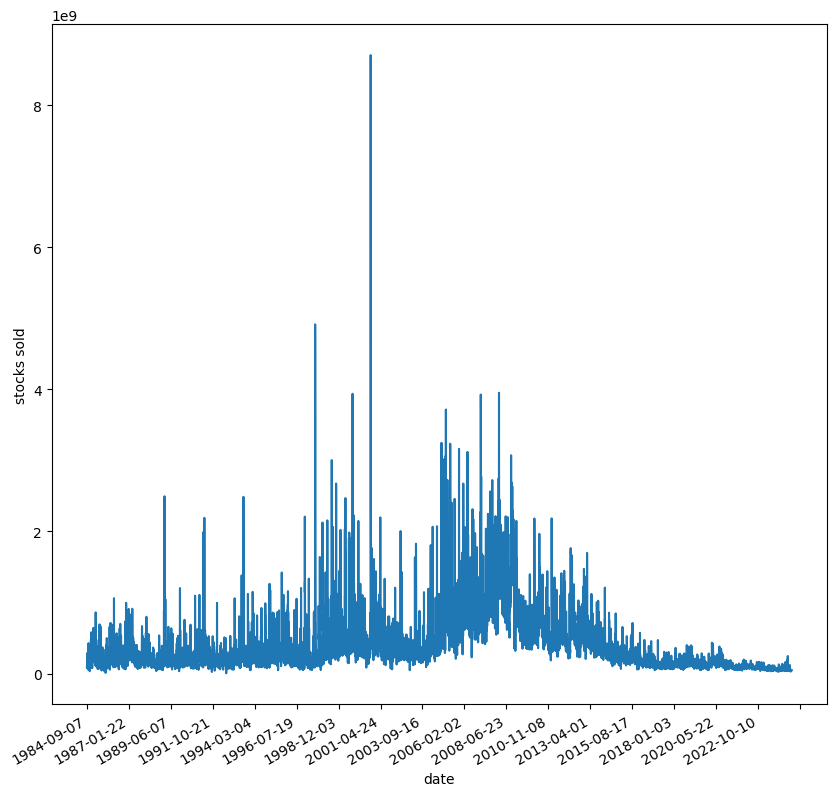

In [772]:
plt.figure(figsize=(10,10))
plt.plot(df["Date"],df["Volume"])
plt.xlabel('date')
plt.ylabel('stocks sold')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.gcf().autofmt_xdate()

<Axes: >

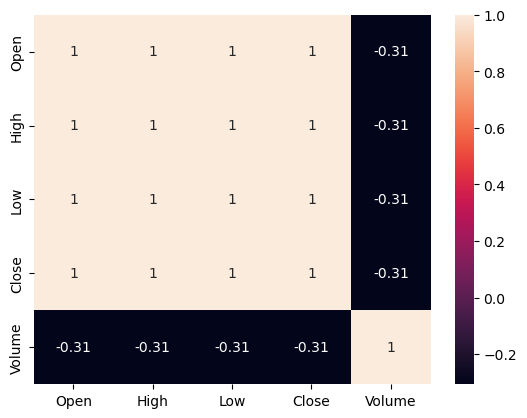

In [773]:
sns.heatmap(df.drop("Date",axis=1).corr(),annot=True)

In [774]:
X=df.drop(["Close",'Date'],axis=1)
y=df.set_index("Date")["Close"]

In [775]:
X

,Open,High,Low,Volume
0,0.100763,0.101999,0.099546,9.767604e+07
1,0.100763,0.101071,0.098340,7.581254e+07
2,0.101071,0.103814,0.101071,1.787705e+08
3,0.101999,0.102597,0.098928,1.561713e+08
4,0.104432,0.104730,0.104432,2.432310e+08
...,...,...,...,...
10075,230.190000,230.400000,227.480000,5.299077e+07
10076,228.550000,229.000000,221.170000,5.019057e+07
10077,221.660000,221.780000,217.480000,4.384020e+07
10078,221.625000,225.480000,221.520000,3.661540e+07


In [776]:
# X=MinMaxScaler().fit_transform(X)
X=StandardScaler().fit_transform(X)

In [777]:
X

array([[-0.49742427, -0.49743832, -0.49729549, -0.72643208],
       [-0.49742427, -0.49745726, -0.49732063, -0.78072951],
       [-0.49741792, -0.49740128, -0.49726372, -0.52503617],
       ...,
       [ 4.07330582,  4.02702824,  4.03279276, -0.86013199],
       [ 4.07258377,  4.10254554,  4.11698412, -0.87807459],
       [ 4.12054813,  4.09764712,  4.08051509, -0.84887989]])

In [778]:
y.shape,X.shape

((10080,), (10080, 4))

In [779]:
max_length = 5

X=np.array([ X[i:i+max_length] for i in range(len(X)-max_length)])
y=np.array([ y[i+max_length] for i in range(len(y)-max_length)])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7932\2048046920.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=np.array([ y[i+max_length] for i in range(len(y)-max_length)])


In [780]:
X

array([[[-0.49742427, -0.49743832, -0.49729549, -0.72643208],
        [-0.49742427, -0.49745726, -0.49732063, -0.78072951],
        [-0.49741792, -0.49740128, -0.49726372, -0.52503617],
        [-0.49739877, -0.49742611, -0.49730837, -0.58116074],
        [-0.49734858, -0.49738258, -0.49719368, -0.36495025]],

       [[-0.49742427, -0.49745726, -0.49732063, -0.78072951],
        [-0.49741792, -0.49740128, -0.49726372, -0.52503617],
        [-0.49739877, -0.49742611, -0.49730837, -0.58116074],
        [-0.49734858, -0.49738258, -0.49719368, -0.36495025],
        [-0.49734243, -0.49730831, -0.49718747, -0.24976439]],

       [[-0.49741792, -0.49740128, -0.49726372, -0.52503617],
        [-0.49739877, -0.49742611, -0.49730837, -0.58116074],
        [-0.49734858, -0.49738258, -0.49719368, -0.36495025],
        [-0.49734243, -0.49730831, -0.49718747, -0.24976439],
        [-0.49726076, -0.49727085, -0.49710496, -0.40743544]],

       ...,

       [[ 4.16273614,  4.17132753,  4.18721306, -0.

In [781]:
y

array([1.05937e-01, 1.08689e-01, 1.04730e-01, ..., 2.20850e+02,
       2.22380e+02, 2.20860e+02])

In [782]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Model

In [783]:
model=Sequential()

In [784]:
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(1,activation='linear'))

In [785]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics='mean_absolute_error')

In [786]:
X_train

array([[[-0.49441531, -0.49447402, -0.494402  , -0.21643226],
        [-0.49451095, -0.49457413, -0.49447265, -0.49340069],
        [-0.49449677, -0.49456723, -0.49456032, -0.41554408],
        [-0.4945671 , -0.49463008, -0.49469994, -0.20501169],
        [-0.49485464, -0.49482197, -0.49472028, -0.2465503 ]],

       [[-0.49224364, -0.49225648, -0.49207405, -0.63487066],
        [-0.49220434, -0.49223756, -0.49203687, -0.69357314],
        [-0.49220434, -0.49218201, -0.49205638, -0.66469497],
        [-0.49210481, -0.49213827, -0.49205638, -0.51289748],
        [-0.49220434, -0.49229922, -0.49219371, -0.66133408]],

       [[-0.47540467, -0.47550338, -0.47540066,  0.16873211],
        [-0.47549296, -0.47566013, -0.47531751,  0.16087386],
        [-0.47548677, -0.47559686, -0.47532376,  1.26823845],
        [-0.47386609, -0.47341563, -0.47384437,  5.13805097],
        [-0.47384546, -0.47369239, -0.47370099,  1.03503493]],

       ...,

       [[-0.44837732, -0.44877209, -0.44941616,  3.

In [787]:
with tf.device('/GPU:0'):
    hist=model.fit(X_train,y_train,epochs=20,batch_size=64,validation_split=0.1,verbose=1)

Epoch 1/20
114/114 [==============================] - 4s 14ms/step - loss: 2686.9675 - mean_absolute_error: 26.1031 - val_loss: 2387.5459 - val_mean_absolute_error: 26.5234
Epoch 2/20
114/114 [==============================] - 1s 8ms/step - loss: 2441.0479 - mean_absolute_error: 29.3848 - val_loss: 2308.1504 - val_mean_absolute_error: 29.0469
Epoch 3/20
114/114 [==============================] - 1s 7ms/step - loss: 2392.0740 - mean_absolute_error: 30.9818 - val_loss: 2295.5015 - val_mean_absolute_error: 30.4604
Epoch 4/20
114/114 [==============================] - 1s 7ms/step - loss: 2383.8767 - mean_absolute_error: 32.0185 - val_loss: 2294.5076 - val_mean_absolute_error: 30.9300
Epoch 5/20
114/114 [==============================] - 1s 8ms/step - loss: 2382.5283 - mean_absolute_error: 32.2755 - val_loss: 2294.0720 - val_mean_absolute_error: 31.0239
Epoch 6/20
114/114 [==============================] - 1s 7ms/step - loss: 2381.7944 - mean_absolute_error: 32.2707 - val_loss: 2293.6147 - 

In [788]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 5, 256)            267264    
                                                                 
 lstm_35 (LSTM)              (None, 5, 64)             82176     
                                                                 
 dense_40 (Dense)            (None, 5, 1)              65        
                                                                 
Total params: 349,505
Trainable params: 349,505
Non-trainable params: 0
_________________________________________________________________


# eval

In [789]:
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 4ms/step - loss: 2311.4766 - mean_absolute_error: 31.7562


[2311.4765625, 31.756237030029297]

In [790]:
y_pred=model.predict(X_test)

63/63 [==============================] - 1s 4ms/step


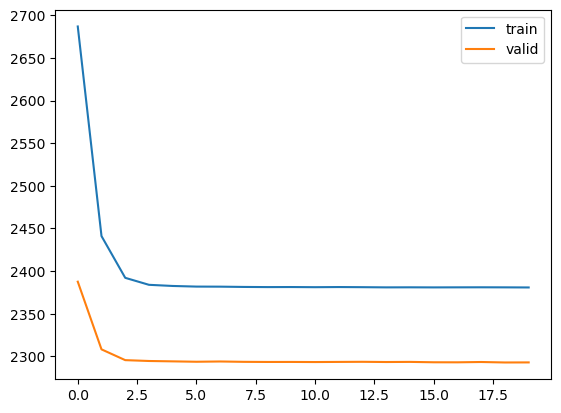

In [791]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train', 'valid'])

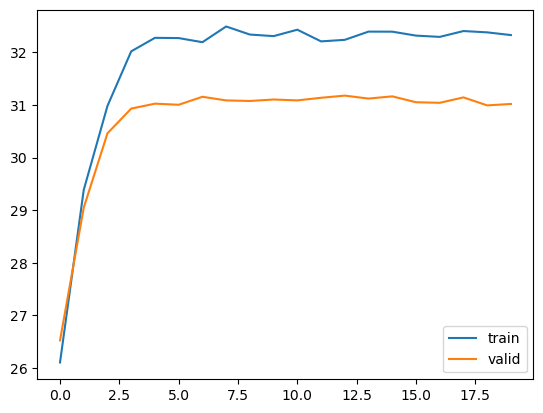

In [792]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.legend(['train', 'valid'])

In [793]:
# model.save("model.h5")